<a href="https://colab.research.google.com/github/shiyunzhu/CS155_Shakespeare_Sonnet_Generator/blob/master/CS155_Shakespeare_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shakespeare Poem Generation Project
Team: Random Variable <br>
Members: Shiyun Zhu and Ruy Gonzalez Hermosillo

First, we will download all of the files that have been uploaded to a caltech box folder. This includes the rnn_weights used to train the initial character based rnn.

In [0]:
!wget -O rnn_weights.h5 https://caltech.box.com/shared/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5
!wget -O HMM.py https://caltech.box.com/shared/static/93vnij0hcch0n2cp94vpuiq8212rcag3.txt
!wget -O shakespeare.txt https://caltech.box.com/shared/static/bjne8xnfj837x08jdjcpn5wyuvxyxc6o.txt
!wget -O spenser.txt https://caltech.box.com/shared/static/x74i336v1g85efp8us53kvf84l5jxc80.txt
!wget -O Syllable_dictionary.txt https://caltech.box.com/shared/static/s34wjgrrn95pypu0yomayybzoa9cv9aa.txt
!wget -O rnn_trained_words_weights.h5 https://caltech.box.com/shared/static/bmb6nnxkoykw8ggikfdbddq50f0945hn.h5

--2020-03-27 21:08:58--  https://caltech.box.com/shared/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5
Resolving caltech.box.com (caltech.box.com)... 107.152.27.197, 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5 [following]
--2020-03-27 21:08:58--  https://caltech.box.com/public/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5 [following]
--2020-03-27 21:08:58--  https://caltech.app.box.com/public/static/zkej2memows5wp3lkg3q1eyz8k4rwb7d.h5
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP request s

## Pre-processing
First, we will load in the data and decide what we are going to do with it in order to be able to use it for HMM. We will be using the NLTK tweet tokenizer to tokenize the poems. As of right now, we are treating each line as a sequence and grouping lines together by poem. We are removing all punctuation from the sequences.

In [0]:
import numpy as np
import pandas as pd
from nltk.tokenize import TweetTokenizer
import string 

In [0]:
tknzr = TweetTokenizer()
poems = []

# Open the file
all_text = open("shakespeare.txt")
poem = []
count = 0

# For each line, we run the tokenizer and store each line
# as an array of words in an array called poem that is then
# added to the poems array.
for line in all_text:
    token_line = tknzr.tokenize(line)
    if len(token_line) > 1:
        poem.append(token_line)
    if len(token_line) == 0 and len(poem) > 0:
        poems.append(poem)
        poem = []
        count += 1

poems.append(poem)
count += 1

all_text.close()

Note that the TweetTokenizer function treats leading and trailing apostrophes as their own word. Same thing with commas, periods, and any punctuation we don't necessarily want to train on these so we will omit them in the preprocessing method below. We also make all words lower case, this is so that we don't treat the lower and upper case version of a word differently.

In [0]:
def removePunctuationAndLowercase(poems):
  new_poems = []
  for poem in poems:
    new_poem = []
    for line in poem:
      new_line = []
      for word in line:
        # Check if a "word" is not punctuation
        if (len(word) > 1 or not word in string.punctuation):
          # here we add the lowercase version of the word
          new_line.append(word.lower())
      new_poem.append(new_line)
    new_poems.append(new_poem)
  return new_poems


In [0]:
pross_poems = removePunctuationAndLowercase(poems)

Now, we need to convert our poems, with words into lists of integers from from 0 to D-1, where D is the number of unique words. To do this, we will construct a dictionary of words to their index.

In [0]:
def convert_to_ints_line(poems):
    '''
       This function takes in a poem and converts all of the words to an index
       and then returns a list of lists, where each list is a line from the
       poem
    '''
    int_list = []
    word_list = []
    word_dict = {}
    unique_words = 0
    for poem in poems:
        for line in poem:
            new_line = []
            for word in line:
                if word in word_dict:
                    new_line.append(word_dict[word])
                else:
                    word_dict[word] = unique_words
                    word_list.append(word)
                    new_line.append(unique_words)
                    unique_words += 1
            int_list.append(new_line)
    
    return int_list, word_list, word_dict, unique_words

In [0]:
data, word_list, word_dict, unique_words = convert_to_ints_line(pross_poems)
print('There are', unique_words, 'unique words in the collection of sonnets')

There are 3205 unique words in the collection of sonnets


## Unsupervised Learning
Use the Baum-Welch algorithm from HW6.

In [0]:
import HMM

## Poetry Generation Part 1
Use the HMM module to write a naive poem generation program that generates 14 lines.

Now, lets write the function to generate a poem.

In [0]:
def hmm_poem_generation(HMM, word_list, lines=14):
    '''
        This function takes in a trained HMM and word list and generates a 14 
        line poem naively.
        ------------------------------------------------------------------------
        Parameters:
        HMM - trained HiddenMarkovModel object from the HW6 HMM module
        word_list - a list of words stored at the index that they are assigned
                    to in the dictionary
        lines - number of lines to generate
        -----------------------------------------------------------------------
        The function prints out the poem and returns the poem as a string
    '''
    poem = ""
    M = 6
    for _ in range(lines):
        line_inds, _ = HMM.generate_emission(M)
        line = ""
        for ind in line_inds:
            word = word_list[ind]
            line += word
            line += " "
        poem += line
        poem += "\n"
    print(poem)
    return poem


In [0]:
hmm1 = HMM.unsupervised_HMM(data, 1, 10, verbose=True)
print()
poem1 = hmm_poem_generation(hmm1, word_list)

Ending probability is: 2.015261060754594e-18

glass all works frame story in 
live as those when art which 
seldom not life my spite thou 
thee his white in said apple 
fled heart what self and true 
thou be can their mistaking me 
compared in defects by the it 
o and a ever but to 
love eyes thee made comments o 
so to but me death straight 
self me or fair brain to 
eye thee sun extern being to 
of thousand sessions in muse how 
might which yet fell hath with 



In [0]:
hmm2 = HMM.unsupervised_HMM(data, 5, 10)
print()
poem2 = hmm_poem_generation(hmm2, word_list)


and that sadly bright thy doth 
bad eyes bad in shame self 
this delivers princes when so that 
in i twilight flowers sooner of 
i of and boot as make 
yet i of with that me 
of to free were thy on 
by doth which my feature play 
thy thee created captain fear time's 
lie and other thy thy still 
asleep full themselves filching the feast 
thy in leads thou breath hath 
of broad thy the not is 
these sweetest what be and world 



In [0]:
hmm4 = HMM.unsupervised_HMM(data, 25, 10, verbose=True)
print()
poem3 = hmm_poem_generation(hmm4, word_list)

Ending probability is: 3.076370996535023e-18

winds the power spend astonished so 
thy i my my private my 
things to our death scarlet spent 
rare one him that serving mourn 
in truth wilt fair beside virtue 
as me fill yield waste blood 
to bars in most strong not 
die or you not far my 
store account lost i say present 
bide the time thy lends my 
heart in the now whose which 
mine thy depends whose shame can 
thy mistress true where thee deceived 
then to your whose in love 



## Poetry Generation Part 2
Now, we will try to use a recurrent neural network to generate the poem.

First, lets create the training data by generating 40 character sequences from the entire text.

In [0]:
def create_lstm_data(n=1, len_seq=40):
    '''
        This function takes generates a list of len_seq character sequences
        and returns the x and y used for training a RNN.
        ------------------------------------------------------------------------
        Parameters:
        n - the number of characters to skip in between sequence generation
            (default is 1)
        len_seq - the length of each sequence to generate (default is 40)
        ------------------------------------------------------------------------
        Return:
        x - (num_seq, len_seq, num_char) shape array where we are storing all
            the characters as 1-hot encoded vectors
        y - (num_seq, num_char) shape array where we are storing all the 
            characters as 1-hot encoded vectors
        char_dict - character to index dictionary
        char_list - list of characters where each character is at their index
    '''
    all_text = open("shakespeare.txt")

    total_work = []
    char_dict = {}
    char_list = []
    num_chars = 0

    # First we want to change the entire text into a large sequence of
    # ints where each int represents a unique character.
    for line in all_text:
        token_line = tknzr.tokenize(line)
        if len(token_line) > 1:
            line = line.lower()
            for char in line:
                if char in char_dict:
                    total_work.append(char_dict[char])
                else:
                    char_dict[char] = num_chars
                    char_list.append(char)
                    total_work.append(num_chars)
                    num_chars += 1
    all_text.close()

    # Now, we will create the sequences and the targets
    int_seqs = []
    targets = []
    for i in range(0, len(total_work) - len_seq, n):
        int_seqs.append(total_work[i:(i + len_seq)])
        targets.append(total_work[i + len_seq])

    # Finally, we will create the x and the y, which are matrices
    # of 1-hot encoded vectors
    x = np.zeros((len(int_seqs), len_seq, len(char_list)),dtype=int)
    y = np.zeros((len(targets), len(char_list)), dtype=int)

    for i, seq in enumerate(int_seqs):
        for t, char in enumerate(seq):
            x[i][t][char] = 1
        y[i][targets[i]] = 1


    return x, y, char_dict, char_list

In [0]:
len_seq = 40
n = 5

x, y, char_dict, char_list = create_lstm_data(n=n, len_seq=len_seq)
print(len(x))

18850


Now, lets build the model that we will train on.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [0]:
model = tf.keras.Sequential(name='sequential')

model.add(layers.LSTM(128, input_shape = (len_seq, len(char_list))))
model.add(layers.Dense(len(char_list), activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               85504     
_________________________________________________________________
dense (Dense)                (None, 38)                4902      
Total params: 90,406
Trainable params: 90,406
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=['accuracy'])

Here, we will use early stopping to stop the training when the decrease in loss has stopped changing.

In [0]:
early_stopping = EarlyStopping(monitor='acc', 
                               min_delta=1e-5, 
                               verbose=0, 
                               mode='max', 
                               restore_best_weights=True)
callbacks_list = [early_stopping]
# we won't actually train the model because it takes time and we have the file
# containing the weights already downloaded.

# model.fit(x=x, y=y, batch_size=64, epochs=200, callbacks=callbacks_list, verbose=0)

In [0]:
# We don't want to run this every time since we don't need to (we have weights saved 
# that we download and use from a previous training, so we don't have to retrain
# every time). However, if we want to get the perxplexity of the model
# we need to run model.fit
history = model.fit(x=x, y=y, batch_size=64, epochs=200, callbacks=callbacks_list, verbose=0)
train_loss = history.history["loss"][-1]
print("Training Loss ", train_loss)
perplexity = tf.exp(train_loss)
print("Perplexity: ", perplexity)
with tf.Session() as sess: 
    print(sess.run(perplexity))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training Loss  0.37156904167458615
Perplexity:  Tensor("Exp:0", shape=(), dtype=float64)
1.4500079536228634


After training, we want to save the weights so that we can load them into new models later on.

In [0]:
# There are no weights to save so we need to comment this out
# model.save_weights('rnn_weights.h5', overwrite=True, save_format='h5')

Now, lets use the trained version and generate something. First, we need to add a lambda layer to create new models and load the trained weights. Since the lambda layer has no weights, the loading method will happily skip those layers when loading in the weights from the saved file

In [0]:
temps = [0.25, 0.75, 1.5]
models = []

# we train different LSTM models with different temperatures
for t in temps:
    # First we build the model
    model_temp = tf.keras.Sequential(name='sequential temp=%f'%t)

    model_temp.add(layers.LSTM(128, input_shape = (len_seq, len(char_list))))
    # This lambda layer represents the temperature parameter
    model_temp.add(layers.Lambda(lambda x: x / t))
    model_temp.add(layers.Dense(len(char_list), activation='softmax'))
    model_temp.load_weights('rnn_weights.h5')
    model_temp.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=['accuracy'])

    # Now add the model to the models list
    models.append(model_temp)

Now that we have a list of trained models with the lambda layer, we can actually generate poems for each of the temperature values.

In [0]:
def random_char(prob_dist, char_list):
    '''
       Generates a random character
       -------------------------------------------------------------------------
       Parameters:
       prob_dist - probability distribution over all of the characters
       -------------------------------------------------------------------------
       Return:
       character
       index of character
    '''
    ind = np.random.choice(len(char_list), size=1, replace=False, p=prob_dist)[0]
    return char_list[ind], ind

In [0]:
def rnn_poem_generation(first_line, char_dict, char_list, model):
    '''
       This function takes generates a poem based on a seed and a trained model.
       -------------------------------------------------------------------------
       Parameters:
       first_line - a 40 character string that is the initial seed
       char_dict - character to index dictionary
       char_list - an array of characters where each character is at their index
       model - a trained RNN model with a lambda layer
       -------------------------------------------------------------------------
       Return:
       generated_poem - a 14 line poem
    '''
    # First we convert the first_line into the right format to train on
    seed = np.zeros((1, len(first_line), len(char_list)), dtype=int)
    i = 0
    for ch in first_line:
        seed[0][i][char_dict[ch]] = 1 
        i += 1
    
    # We predict on a 40-character window
    # Initially we predict on the seed
    window = seed
    # We generate 14 lines 
    desired_num_lines = 14
    max_char = 1e4
    new_line_char_count = 0
    total_char_count = 0
    generated_poem = ""
    while (new_line_char_count < desired_num_lines and total_char_count < max_char):
        # Predict a character based on the 40-character window
        prediction = model.predict(window, verbose=0)
        result, pred_index = random_char(prediction[0], char_list)
        # result = char_list[pred_index]
        generated_poem += result
        total_char_count += 1
        if (pred_index == char_dict["\n"]):
            # then we have a new line, so increment number of lines we've made
            new_line_char_count += 1
        # Now we shift the window used to predict by one character
        # (adding the newly predicted character)
        newly_predicted = np.zeros(len(char_list), dtype=int)
        newly_predicted[pred_index] = 1
        # print(newly_predicted.shape)
        # print(window.shape)
        new_seq = window[0].tolist()
        new_seq.append(newly_predicted.tolist())
        new_seq = new_seq[1:len(new_seq)]
        window[0] = new_seq
        #print(generated_poem)
    return generated_poem

In [0]:
i = 0
np.random.seed(2020)
seed = "shall i compare thee to a summer's day?\n"
# Now we actually generate poems
for model in models:
  # Finally we generate a poem based on this model
  poem = rnn_poem_generation(seed, char_dict, char_list, model)

  print("Generated Poem with a temperature of ", temps[i])
  print(poem)
  i += 1

Generated Poem with a temperature of  0.25
o  frruit self is inking oo hast thee,
and i de thee with thing that dost ind thy selfer'st the had,
the will is sich agloud beauty seart,
  and se pyising hippuit myou shen in see,
whell not to thy sweed where thou ast look shell,
thece the gilnce his i barn the rese thee from thee,
which thou the gient with me and lidsupare,
ans is seftisede i have rourspied offere
the ling to thy surbuints swart,
those asting not the seast that i mark of thee,
whech not self-love, thou of speartises bran
thee all re preat you with my sown's sime.
  ther of the warth make thind now ast chur,
  so cunt of chind in ey,

Generated Poem with a temperature of  0.75
hise is spisting no pastounto so nown.
so didgh a dowh anee in thie scacts con relovery,
and shee im mine own thee, as by thee,
whe what i se vense stores so doy spentis,
to sweet him with chult withte, noom to heart's rernof thee,
wheching not to haster and lid propsend,
so she thy mage three tom seav

## HMM with Rhyme and Syllables
Shakespeare sonnets have a rhyming pattern of abab cdcd efef gg and every line strictly has 10 syllables. Thus, we can try to create better sonnets by generating poems that rhyme and have ten syllables per line. To do this, first, we need to generate a rhyming dictionary. We can do this by following this [guide](https://www.garysieling.com/blog/rhyming-with-nlp-and-shakespeare).

In [0]:
import nltk
nltk.download('cmudict')
nltk.download('wordnet')
from nltk.corpus import cmudict

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


This function finds the rhyming words by comparing the pronounciation for the word based on the cmu dictionary. We make sure that there are similar "syllables" for all of the rhyming words. Since we are working with generating poems from the Shakespeare corpus, we will only include the rhyming words that are also from the Shakespeare text. The code for this function is based off of this [guide](https://www.garysieling.com/blog/rhyming-with-nlp-and-shakespeare).

In [0]:
def rhymes(syllables):
    '''
       This function generates a rhyming dictionary using a given list
       of words with pronounciations from cmu dictionary. It then returns a
       dictionary of words with a list of rhyming words as the value. If the
       list is empty, then there are no rhyming words.
    '''
    rhyme_dict = {}
    count = 0
    for (w, l, p) in syllables:
        try:
            filtered = [wt for (wt, lt, pt) in syllables 
                  if wt != w and l == lt
                  and p[-2:] == pt[-2:] 
                  and (nltk.distance.edit_distance(w, wt) > 2 \
                  or not w[0:2] == wt[0:2])
                  and len(nltk.corpus.wordnet.synsets(wt)) > 0]
            rhyme_dict[w] = filtered
        except:
            rhyme_dict[w] = []
        count += 1
        if count % (len(syllables) / 10) == 0:
            print('=', end='')
    return rhyme_dict

Now, we will find the rhyming words for every single word in the Shakespeare text. We do that by going through the list of words and adding the pronounciation from cmudict and using the above function.

In [0]:
cmudictionary = cmudict.dict()
syllables = []
for w in word_list:
    p = cmudictionary.get(w)
    if p != None:
        syllables.append((w, len(p[0]), p[0]))

rhyme_dict = rhymes(syllables)

Now, lets load in the syllable dictionary.

In [0]:
syllable_dict_text = open('Syllable_dictionary.txt')
syllable_dict = {}
for line in syllable_dict_text:
    lst = line.split()
    syllable_dict[lst[0]] = lst[1:]
syllable_dict_text.close()

Now that we have everything set up, lets try generating poems from a trained HMM. First we will need a function to generate a line. This function is able to generate lines that have exactly 10 syllables and lines that end with a word that rhymes with an input seed word.

In [0]:
def generate_line_rhyme_syllable(HMM, word_list, word_dict, rhyme_dict, 
                                 syllable_dict, seed=''):
    '''
        This function generates a line of words based on a trained HMM. It can
        generate a line normally, or based on a seed word backwards.
        ------------------------------------------------------------------------
        Parameters:
        HMM - trained HiddenMarkovModel object from the HW6 HMM module
        word_list - a list of words stored at the index that they are assigned
                    to in the dictionary
        word_dict - a dictionary of words and their indices
        rhyme_dict - a dictionary of words that rhyme in the shakespeare sonnet
                     corpus
        syllable_dict - syllable dictionary
        seed - the word to rhyme with, if any
        ------------------------------------------------------------------------
        Returns:
        line - 'ERROR' string if there was an error generating the line or the
               line itself
    '''
    max_syllables = 10
    syllable_count = 0
    word_count = 0
    L = HMM.L
    D = HMM.D
    A = np.array(HMM.A)
    O = np.array(HMM.O)
    A_start = HMM.A_start

    emissions = []
    states = []
    line = ''


    # If there is no seed, then we do not have to worry about rhyme
    if seed == '':
        while syllable_count < max_syllables:
            if syllable_count == 0:
                state_probs = A_start
            else:
                state_probs = A[states[word_count - 1], :]
            
            state = np.random.choice(L, p=state_probs)

            emission_probs = O[state, :]
            emission = np.random.choice(D, p=emission_probs)
            word = word_list[emission]
            syllable_lst = syllable_dict.get(word)
            if syllable_lst == None:
                syllable_lst = []

            for syllable in syllable_lst:
                if syllable[0] == 'E':
                    s = int(syllable[1:])
                    new_count = syllable_count + s
                    if new_count == max_syllables:
                        syllable_count = new_count
                        line += word
                        return line
                else:
                    s = int(syllable)
                    new_count = syllable_count + s
                    if new_count <= max_syllables:
                        syllable_count = new_count
                        line += word + ' '
                        emissions.append(emission)
                        states.append(state)
                        word_count += 1
                        break
        return line

    # If there is a seed, we first find a word to rhyme with it
    rhymes = rhyme_dict.get(seed)
    if rhymes == None:
        return 'ERROR'
    
    rhymes.append(seed)

    for first in rhymes:
        first_ind = word_dict[first]

        # choose a first state
        init_state_probs = O[:,first_ind] / np.sum(O[:, first_ind])
        state = np.random.choice(L, p=init_state_probs)
    
        syllable_lst = syllable_dict.get(first)
        if syllable_lst == None:
            syllable_lst = []

        for syllable in syllable_lst:
            if syllable[0] == 'E':
                s = int(syllable[1:])
                syllable_count += s
            else:
                s = int(syllable)
                syllable_count += s

        if syllable_count != 0:
            emissions = [first_ind]
            states = [state]
            break

    if syllable_count == 0:
        return 'ERROR'

    while syllable_count < max_syllables:
        state_probs = A[:, states[word_count - 1]] / np.sum(A[:, states[word_count - 1]])
        state = np.random.choice(L, p=state_probs)
        states.append(state)
        
        obs_probs = O[state]
        obs = np.random.choice(D, p=obs_probs)
        word = word_list[obs]

        syllable_lst = syllable_dict.get(word)
        if syllable_lst == None:
            syllable_lst = []
        
        for syllable in syllable_lst:
            if syllable[0] != 'E':
                s = int(syllable)
                new_count = syllable_count + s
                if new_count <= max_syllables:
                    syllable_count = new_count 
                    emissions.append(obs)
                    states.append(state)
                    word_count += 1
                    break   
    
    line = ""
    for ind in emissions[::-1]:
        word = word_list[ind]
        line += word
        line += " "
    return line

Now, we will write a function to have generate a 14 line sonnet that rhymes and has 10 syllables per line.

In [0]:
def hmm_poem_generation_rhyme_syllable(HMM, word_list, word_dict, rhyme_dict,
                                       syllable_dict):
    '''
        This function takes in a trained HMM and word list and generates a 14 
        line poem with rhyming in the patter of abab cdcd efef gg
        ------------------------------------------------------------------------
        Parameters:
        HMM - trained HiddenMarkovModel object from the HW6 HMM module
        word_list - a list of words stored at the index that they are assigned
                    to in the dictionary
        word_dict - a dictionary of words and their indices
        rhyme_dict - a dictionary of words that rhyme in the shakespeare sonnet
                     corpus
        -----------------------------------------------------------------------
        The function prints out the poem and returns the poem as a string
    '''
    poem = ""
    M = 6
    for _ in range(3):
        while True:
            line1 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                                 rhyme_dict, syllable_dict)
            words1 = line1.split()
            line3 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                                 rhyme_dict, syllable_dict, 
                                                 seed=words1[len(words1) - 1])
            if line3 != 'ERROR':
                break
        
        while True:
            line2 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                                 rhyme_dict, syllable_dict)
            words2 = line2.split()
            line4 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                                 rhyme_dict, syllable_dict, 
                                                 seed=words2[len(words2) - 1])
            if line4 != 'ERROR':
                break
        
        poem += (line1 + '\n' + line2 + '\n' + line3 + '\n' + line4 + '\n')
        # Make into stanzas
        poem += ('\n')

    while True:
        line1 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                             rhyme_dict, syllable_dict)
        words1 = line1.split()
        line2 = generate_line_rhyme_syllable(HMM, word_list, word_dict, 
                                             rhyme_dict, syllable_dict, 
                                             seed=words1[len(words1) - 1])
        if line2 != 'ERROR':
            poem += (line1 + '\n' + line2)
            break

    print(poem)
    return poem

In [0]:
hmm = HMM.unsupervised_HMM(data, 5, 50, verbose=True)

Ending probability is: 2.4296604201893207e-17


In [0]:
poem = hmm_poem_generation_rhyme_syllable(hmm, word_list, word_dict, rhyme_dict, syllable_dict)

thee keeps not thy soul health my graciously 
men's thy good of chide too throw self thee i 
but thee the stol'n foiled truth lives i strangely 
thou of show gazing death trust our by eye 

i your faults youth do inheritors love 
tells canst many fading sense bitter wolf in 
with of the graced lovely with pine dove 
my best fill perceiv'st such eat in in in 

could heaven misuse is to my nature praise 
which yet have thy praise fair delves my with cherish
i to virgin in save the sweet sweet phrase 
the it not if unfathered perish 

wrinkles thou deep in not alone though no 
time's nothing thee o have worthy thou know 


## Improving RNN
Here we try training on and generating entire words rather than characters 

In [0]:
# First we create new training data, this time with entire words
def create_lstm_data_words(n=1, len_seq=10):
    '''
        This function takes generates a list of len_seq word sequences
        and returns the x and y used for training a RNN.
        ------------------------------------------------------------------------
        Parameters:
        n - the number of words to skip in between sequence generation
            (default is 1)
        len_seq - the length of each sequence to generate (default is 10 words)
        ------------------------------------------------------------------------
        Return:
        x - (num_seq, len_seq, num_words) shape array where we are storing all
            the words as 1-hot encoded vectors
        y - (num_seq, num_words) shape array where we are storing all the 
            words as 1-hot encoded vectors
        word_dict - word to index dictionary
        word_list - list of words where each character is at their index
    '''
    all_text = open("shakespeare.txt")

    total_work = []
    word_dict = {}
    word_list = []
    num_words = 0

    # First we want to change the entire text into a large sequence of
    # ints where each int represents a unique word
    for line in all_text:
        token_line = tknzr.tokenize(line)
        # this checks if the line is a single number or not 
        # as the text sometimes has this to indicate the start of a poem
        if len(token_line) > 1:
            line = line.lower()
            word = ""
            # we define a word as every character up to and including
            # a space that terminates it
            # if instead it is punctuation that terminates it
            # we add a space anyways and we consider the punctuation another word
            for char in line:
                if char.isalpha() or char == "'" or char == "-":
                    # if it's just another letter, add it to the word
                    word += char
                    continue
                if char == " ":
                    # the word is finished! add it to dictionary if needed
                    if (word == ""):
                        continue
                    word += char
                    if word in word_dict:
                        total_work.append(word_dict[word])
                        word = ""
                    else:
                        word_dict[word] = num_words
                        word_list.append(word)
                        total_work.append(num_words)
                        num_words += 1
                        word = ""
                    continue
                # we have a punctuation! Add it as a word of its own
                elif (len(word) > 1):
                    # if the preceding word doesn't have a space before puncutation
                    # then still save it as a word on its own 
                    if word in word_dict:
                        # note that we always make sure there is a space after 
                        # each word. This means we don't have to worry about 
                        # generating spaces 
                        total_work.append(word_dict[word + " "])
                    else:
                        word_dict[word + " "] = num_words
                        word_list.append(word + " ")
                        total_work.append(num_words)
                        num_words += 1
                # If the character is a new line, :, or comma, we  don't 
                # train on it (this seems to give better results
                # and when generating, we force a new line after every 10 words)
                if (char == "\n" or char == "," or char == ":" or char == "(" or char ==")"):
                    word = ""
                    continue
                word = char
                if word in word_dict:
                    total_work.append(word_dict[word + " "])
                    word = ""
                else:
                    word_dict[word + " "] = num_words
                    word_list.append(word + " ")
                    total_work.append(num_words)
                    num_words += 1
                    word = ""
    all_text.close()

    # Now, we will create the sequences and the targets
    int_seqs = []
    targets = []
    for i in range(0, len(total_work) - len_seq, n):
        int_seqs.append(total_work[i:(i + len_seq)])
        targets.append(total_work[i + len_seq])

    # Finally, we will create the x and the y, which are matrices
    # of 1-hot encoded vectors
    x = np.zeros((len(int_seqs), len_seq, len(word_list)),dtype=int)
    y = np.zeros((len(targets), len(word_list)), dtype=int)

    for i, seq in enumerate(int_seqs):
        for t, word in enumerate(seq):
            x[i][t][word] = 1
        y[i][targets[i]] = 1


    return x, y, word_dict, word_list

In [0]:
len_seq = 7
n = 3 # we skip in order to make training faster

x, y, word_dict, word_list = create_lstm_data_words(n=n, len_seq=len_seq)
print(len(x))

6038


In [0]:
model = tf.keras.Sequential(name='sequential')

model.add(layers.LSTM(128, input_shape = (len_seq, len(word_list))))
model.add(layers.Dense(len(word_list), activation='softmax'))
model.summary()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               3018240   
_________________________________________________________________
dense_1 (Dense)              (None, 5766)              743814    
Total params: 3,762,054
Trainable params: 3,762,054
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = EarlyStopping(monitor='acc', 
                               min_delta=1e-5, 
                               verbose=0, 
                               mode='max', 
                               restore_best_weights=True)
callbacks_list = [early_stopping]

# since we've trained this already, we just use the saved weights
#model.fit(x=x, y=y, batch_size=64, epochs=200, callbacks=callbacks_list, verbose=0)
#model.save_weights('rnn_trained_words_weights.h5', overwrite=True, save_format='h5')

In [0]:
# again, we can run this code only if we want to know the perplexity
history = model.fit(x=x, y=y, batch_size=64, epochs=200, callbacks=callbacks_list, verbose=0)
train_loss = history.history["loss"][-1]
print("training loss = ", train_loss)
perplexity = tf.exp(train_loss)
print("Perplexity: ", perplexity)
with tf.Session() as sess: 
    print(sess.run(perplexity))

training loss =  6.87366606423933
Perplexity:  Tensor("Exp_1:0", shape=(), dtype=float64)
966.4852760558038


In [0]:
temps = [0.25, 0.75, 1.5]
models = []

# we create different LSTM models with different temperatures
for t in temps:
    # First we build the model
    model_temp = tf.keras.Sequential(name='sequential temp=%f'%t)

    model_temp.add(layers.LSTM(128, input_shape = (len_seq, len(word_list))))
    # This lambda layer represents the temperature parameter
    model_temp.add(layers.Lambda(lambda x: x / t))
    model_temp.add(layers.Dense(len(word_list), activation='softmax'))
    model_temp.load_weights('rnn_trained_words_weights.h5')
    model_temp.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=['accuracy'])

    # Now add the model to the models list
    models.append(model_temp)

In [0]:
def rnn_word_poem_generation(first_line, word_dict, word_list, model):
    '''
       This function takes generates a poem based on a seed and a trained model.
       -------------------------------------------------------------------------
       Parameters:
       first_line - a 40 character string that is the initial seed
       word_dict - word to index dictionary
       word_list - an array of words where each word is at their index
       model - a trained RNN model with a lambda layer
       -------------------------------------------------------------------------
       Return:
       generated_poem - a 14 line poem
    '''
    # First we convert the first_line into the right format to train on
    seed = np.zeros((1, 7, len(word_list)), dtype=int)
    word = ""
    num_words = 0
    # we define a word as every character up to and including
    # a space that terminates it
    # if instead it is punctuation that terminates it
    # we add a space anyways and we consider the punctuation another word
    for char in first_line:
        if char.isalpha() or char == "'" or char == "-":
            # if it's just another letter, add it to the word
            word += char
            continue
        if char == "\n" or char == "," or char == ":":
            continue
        if char == " ":
            # the word is finished! add the corresponding integer to seed list
            word += char
            seed[0][num_words][word_dict[word]] = 1 
            num_words += 1
            word = ""
            continue
        # we have a new line or punctuation! Add it as a word of its own
        elif (len(word) > 1):
            # if the preceding word doesn't have a space before puncutation
            # then still save it as a word on its own 
            seed[0][num_words][word_dict[word + " "]] = 1 
            num_words += 1
        word = char
        seed[0][num_words][word_dict[word + " "]] = 1 
        num_words += 1
        word = ""
        continue
    
    # We predict on a 9-word window
    # Initially we predict on the seed
    window = seed
    # We generate 14 lines 
    desired_num_lines = 14
    max_words = 1e3
    new_line_word_count = 0
    total_word_count = 0
    generated_poem = ""
    words_in_line_count = 0
    lines_per_stanza = 0
    while (new_line_word_count < desired_num_lines and total_word_count < max_words):
        # Predict a character based on the 10-word window
        prediction = model.predict(window, verbose=0)
        # technically this returns a random word not char, but it 
        # should work the same way if we pass a word list isntead of 
        # character list 
        result, pred_index = random_char(prediction[0], word_list)
        generated_poem += result
        total_word_count += 1
        words_in_line_count += 1
        if (words_in_line_count == 7):
            # make a new line, so increment number of lines we've made
            new_line_word_count += 1
            words_in_line_count = 0
            generated_poem += "\n"
            lines_per_stanza += 1
            if (lines_per_stanza == 4):
                generated_poem += "\n"
                lines_per_stanza = 0
        # Now we shift the window used to predict by one character
        # (adding the newly predicted character)
        newly_predicted = np.zeros(len(word_list), dtype=int)
        newly_predicted[pred_index] = 1
        # print(newly_predicted.shape)
        # print(window.shape)
        new_seq = window[0].tolist()
        new_seq.append(newly_predicted.tolist())
        new_seq = new_seq[1:len(new_seq)]
        window[0] = new_seq
        #print(generated_poem)
    return generated_poem

In [0]:
i = 0
np.random.seed(2020)
seed = "shall i compare thee to a summer's"
# Now we actually generate poems
for model in models:
  # Finally we generate a poem based on this model
  poem = rnn_word_poem_generation(seed, word_dict, word_list, model)

  print("Generated Poem with a temperature of ", temps[i])
  print(poem)
  i += 1

Generated Poem with a temperature of  0.25
your my and to to the to 
to my the the in and thy 
to and the and the to i 
the and of and and the and 

the and the i thy thy my 
and and and the my and my 
my i the the and and the 
and and to and the to the 

and i my and and and in 
and and the i my when i 
the the and but to and i 
my the the and the that the 

my but my i and and of 
with and the i to i and 

Generated Poem with a temperature of  0.75
to i all heir my a my 
constancy yours anew might but the frequent 
all found not green ? was deaf 
which scope did their to all eyes 

no of my eclipses and the my 
that by by heaven after-loss and to 
thou report such winds have the not 
my which . year but a tenth 

time if with deeds thou life cheek 
whom as eye in think thou he 
for thy what costly that the equipage 
eye to must thus i of thy 

do we the is thou . write 
thy my grew are of the or 

Generated Poem with a temperature of  1.5
earth assure were kill which how decease 
whi

## Visualization
We are going to try to visualize the HMM transition and observation matrices using wordclouds and various graphs.

In [0]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

First, we should retrain and regenerate some poems that we will use to visualize later. Lets compare an HMM with 5 states with one with 10 states.

In [0]:
pross_poems = removePunctuationAndLowercase(poems)
data, word_list, word_dict, unique_words = convert_to_ints_line(pross_poems)

hmm5 = HMM.unsupervised_HMM(data, 5, 50)
poem5 = hmm_poem_generation_rhyme_syllable(hmm5, word_list, word_dict, rhyme_dict, syllable_dict)

print()
hmm10 = HMM.unsupervised_HMM(data, 10, 50)
poem10 = hmm_poem_generation_rhyme_syllable(hmm10, word_list, word_dict, rhyme_dict, syllable_dict)

thou worms youngly disdain child being the shall 
thee dancing measured what bright unlooked to 
lends long in hammered works date mine so shall 
was and now fire that his of precious two 

the i own me shall light nightly full knows 
him we where thee but nor trifle men thy 
a and one thy he her grew is nor rose 
april's it a towards did not if self thy 

time this why show dully my viewest doth 
not self my proud for sweetest brand join and 
truth blanks thoughts so at and lies whether truth's doth 
brains due own will love so faint are is end 

lays duty such the my chest that eat thee 
love think happy your heart of black end thee 

the day some of pyramids graven reeks 
turn kindness find news eye blessed is i 
rider ruined of are thy thriftless looks 
o'er-read much to all day the mad for eye 

so will like that glass although of this is 
love thou speak sharpened and against worst sin 
augurs art thy for divining my is 
of thou thou and wilt live and and and been 

or lines of n

Now lets create some wordclouds featuring the top ten emmited words in each state for both of our HMMs.

In [0]:
def top_n_words(hmm, word_list, filename='toptenwordsstate', n=10):
    L = hmm.L
    D = hmm.D
    A = hmm.A
    O = hmm.O

    for i in range(L):
        probs = O[i]
        word_inds = np.random.choice(D, size=(1000), p=probs)
        words = ""
        for ind in word_inds:
            words += word_list[ind] + " "
        wordcloud = WordCloud(max_words=n, background_color="white").generate(words)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.savefig(filename + str(i) + '.png')
        plt.show()

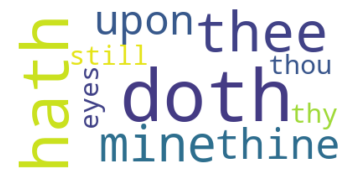

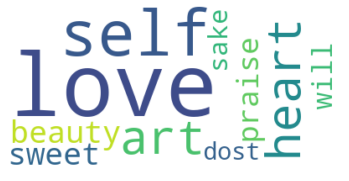

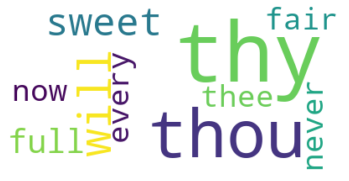

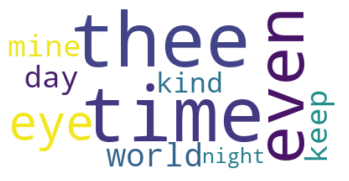

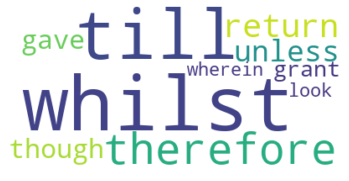

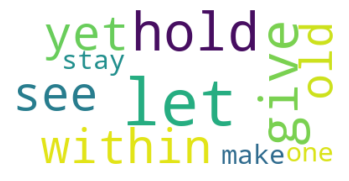

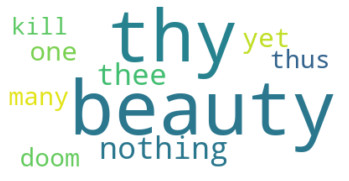

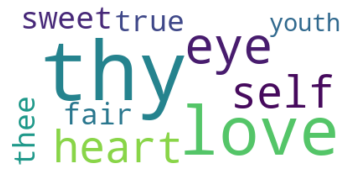

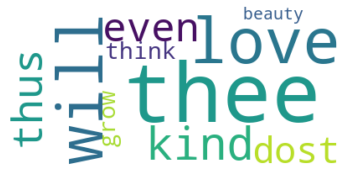

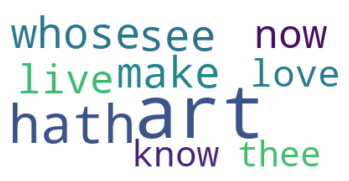

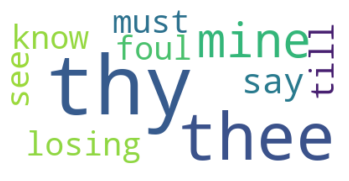

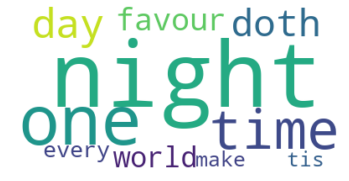

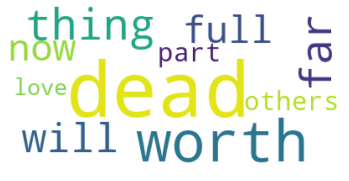

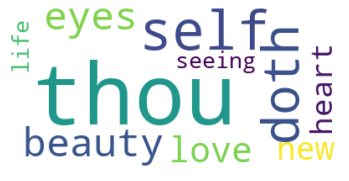

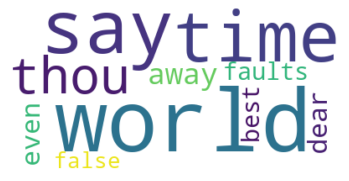

In [0]:
top_n_words(hmm5, word_list, filename='wordcloud_hmm5')
top_n_words(hmm10, word_list, filename='wordcloud_hmm10')

In [0]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from matplotlib import cm

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Now, I want to know if there is a connection between the part of speech of the words in each state and the state. So lets define a function to generate some plots that compare the relative percentage of words that are a certain part of speech for each state.

In [0]:
def parts_of_speech(hmm, word_list, filename='states_by_POS'):
    pos_tagged = nltk.pos_tag(word_list, tagset='universal')
    
    pos_lst = []
    pos_dict = {}
    count = 0
    for (word, pos) in pos_tagged:
        if pos not in pos_lst:
            pos_lst.append(pos)
            pos_dict[pos] = count
            count += 1

    L = hmm.L
    D = hmm.D
    A = hmm.A
    O = hmm.O

    plt.figure()
    legend = []
    # Loops through all of the states
    for i in range(L):
        pos_percentage = np.zeros(len(pos_lst))
        # Loops through every word in the state
        for j in range(D):
            # this gets the part of speech of the word
            pos = pos_tagged[j][1]
            # this adds to the percentage of words that this state 
            # emits that are this part of speech 
            pos_percentage[pos_dict[pos]] += O[i][j]
        # Plot a line for each state 
        plt.plot(np.linspace(1, len(pos_lst), num=len(pos_lst)), pos_percentage, 
                alpha=0.6, marker='o')
        legend.append('State %d' % (i + 1))

    plt.legend(legend)
    plt.xticks(ticks=np.linspace(1, len(pos_lst), len(pos_lst)), labels=pos_lst)
    plt.title('Percentage of Words in State Categorized by Part of Speech')
    plt.savefig(filename + '_A.png')
    plt.show()

    # Now we also want to make another plot, this time with the states on
    # the x-axis (y-axis is still percentage of words in each state
    # that are a particularlar part of speech)
    plt.figure()

    # We add an array containing the percentage of each part of speech 
    # for each state (so this is a 2-d array)
    percentages = []
    labels = []
    # Loops through all of the states
    for i in range(L):
        pos_percentage = np.zeros(len(pos_lst))
        # Loops through every word in the state
        for j in range(D):
            # this gets the part of speech of the word
            pos = pos_tagged[j][1]
            # this adds to the percentage of words that this state 
            # emits that are this part of speech 
            pos_percentage[pos_dict[pos]] += O[i][j]
        # now we add this percentage vector to the list of percentages
        percentages.append(pos_percentage)
        labels.append(str(i + 1))
    # Now we plot 
    plt.plot(np.linspace(1, len(percentages), num=len(percentages)), percentages, 
                alpha=0.6, marker='o', linewidth=0)
    plt.xticks(ticks=np.linspace(1, len(percentages), len(percentages)), 
               labels=labels )
    plt.xlabel("State")
    plt.title('Percentage of Words in State Categorized by Part of Speech')
    plt.legend(pos_lst, bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.savefig(filename + '_B.png', bbox_inches='tight')
    plt.show()

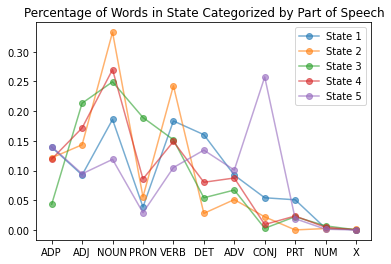

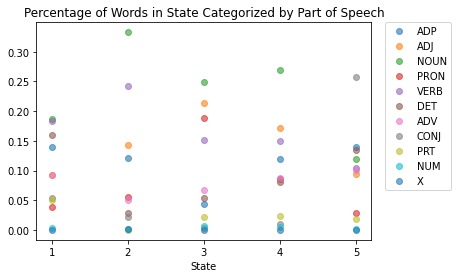

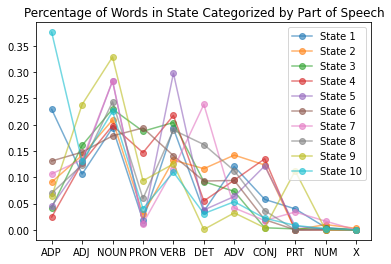

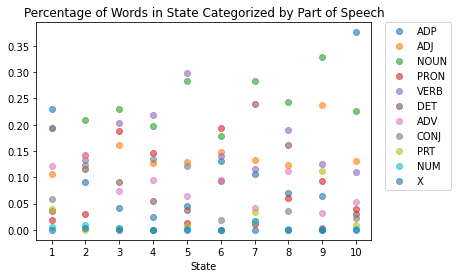

In [0]:
parts_of_speech(hmm5, word_list, 'states_by_POS_hmm5')
parts_of_speech(hmm10, word_list, 'states_by_POS_hmm10')

Now, we want to see if there are trends in the transitions between different parts of speech within each line of a poem.

In [0]:
def parts_of_speech_transition(poem, word_list, filename='poem_by_POS'):
    # tag the part of speech of each word in the shakespeare corpus

    pos_tagged = nltk.pos_tag(word_list, tagset='universal')
    pos_lst = []
    pos_dict = {}
    count = 0
    for (word, pos) in pos_tagged:
        if pos not in pos_lst:
            pos_lst.append(pos)
            pos_dict[pos] = count
            count += 1

    lines = poem.split('\n')

    colors = plt.cm.tab20c(range(20))
    plt.figure()
    i = 0
    poem_pos_lst = []
    legend = []
    for line in lines:
        if len(line) < 2:
            continue
        line_lst = line.split()
        line_pos_lst = []
        pos_tagged_line = nltk.pos_tag(line_lst, tagset='universal')
        for (word, pos) in pos_tagged_line:
            line_pos_lst.append(pos_dict[pos])

        plt.plot(np.linspace(1, len(line_lst), num=len(line_lst)), line_pos_lst, 
                 marker='o', c=colors[i])
        i += 1
        legend.append('Line' + str(i))
    plt.yticks(ticks=np.linspace(0, len(pos_lst) - 1, num=len(pos_lst)), labels=pos_lst)
    plt.grid(b=True, which='major', axis='y', c='grey', alpha=0.3)
    plt.legend(legend, bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.title('Poem Transitions Between POS')
    plt.savefig(filename + '.png', bbox_inches='tight')
    plt.show()

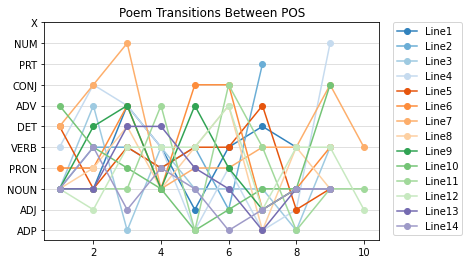

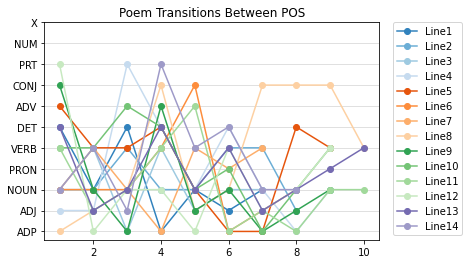

In [0]:
parts_of_speech_transition(poem5, word_list, filename='poem5_by_POS')
parts_of_speech_transition(poem10, word_list, filename='poem10_by_POS')

In [0]:
import networkx as nx
import matplotlib as mpl

Finally, lets try to understand the transitions between states and visuallizing each state as a node in the graph and changing the transparency and thickness of the edge based on its value in the transition matrix.

In [0]:
def view_transitions(hmm, filename='transition_graph'):
    L = hmm.L
    A = np.array(hmm.A)
    G = nx.MultiDiGraph()

    widths = []
    pos = []
    edges = []
    for i in range(L):
        for j in range(L):
            edges.append((i, j))
            G.add_edge(i, j, weight=A[i,j])
            widths.append(A[i,j] * 5)

    pos = nx.layout.shell_layout(G)

    plt.figure()

    nx.draw_networkx_nodes(G, pos=pos, node_size=500)
    ax = plt.gca()
    for i, edge in enumerate(edges):
        ax.annotate("",
                xy=pos[edge[0]], xycoords='data',
                xytext=pos[edge[1]], textcoords='data',
                arrowprops=dict(color="green", alpha=widths[i]/5,
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.3",
                                width=widths[i], headwidth=widths[i] * 5),
                )
    nx.draw_networkx_labels(G, pos=pos)
    plt.title('Graph of Transitions Between States')
    plt.savefig(filename + '.png')
    plt.show()


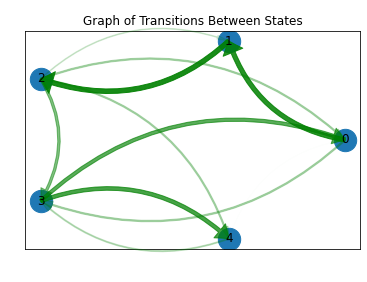

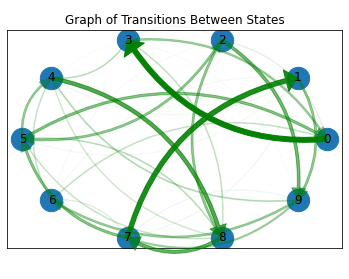

In [0]:
view_transitions(hmm5, 'transition_graph_5states')
view_transitions(hmm10, 'transition_graph_10states')